In [25]:
%pylab widget
from freetype import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from struct import pack, calcsize

def get_glyph(code, is_outline=False):
    face.load_char(code, FT_LOAD_RENDER)
    bitmap = face.glyph.bitmap
    width  = face.glyph.bitmap.width
    rows   = face.glyph.bitmap.rows

    props = {
        'width': width,
        'height': rows,
        'lsb': face.glyph.bitmap_left,
        'tsb': face.glyph.bitmap_top,
        'advance': face.glyph.advance.x // 64
    }   
    return bytes(bitmap.buffer), props

def getImg(ind, dump=False):
    p = glyph_props[ind]
    
    start_ind = p['start_index']
    end_ind = start_ind + p['width'] * p['height']

    bs = glyph_data_bs[start_ind: end_ind]
    if dump:
        hd(bs)
    return Image.frombuffer('L', (p['width'], p['height']), bs)

def get_y_stats(glyph_props):
    us = []
    ls = []
    for i in range(16, 27):
        p = glyph_props[i]
        y_max = p["tsb"]
        y_min = p["tsb"] - p["height"]
        # print(f'{y_max:3d}  {y_min:3d}')
        us.append(y_max)
        ls.append(y_min)
    
    bb_up = int(max(us))
    bb_down = int(min(ls))
    bb_mid = (bb_up + bb_down) / 2
    
    bb_height = bb_up - bb_down
    yshift = int(round(16 - bb_mid))
    
    return bb_height, yshift

def hd(dat, pad_width=1, word_width=None):
    ''' print a hex-dump, word_width in bytes '''
    if word_width is None:
        word_width = pad_width
    for i, d in enumerate(dat):
        if i % 8 == 0 and len(dat) > 8:
            print('\n{:04x}: '.format(i * word_width), end='')
        print('{:0{ww}x} '.format(d, ww=pad_width * 2), end='')
    print()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/michael/.virtualenvs/ipy/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['cast', 'resize']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Generate file

In [14]:
face = Face('./Ubuntu-Regular.ttf')
face.set_char_size(width=33 * 64)

glyph_data_bs = bytes()
glyph_props = []

for c in arange(0x20, 0x20 + 95):
    # print(hex(c), chr(c))

    buf, props = get_glyph(chr(c))

    props["start_index"] =  len(glyph_data_bs)
    props["end_index"] =  len(glyph_data_bs) + len(buf)
    glyph_props.append(props)
    
    glyph_data_bs += buf
    
len(glyph_data_bs)

30709

In [15]:
glyph_props

[{'width': 0,
  'height': 0,
  'lsb': 0,
  'tsb': 0,
  'advance': 8,
  'start_index': 0,
  'end_index': 0},
 {'width': 5,
  'height': 23,
  'lsb': 2,
  'tsb': 23,
  'advance': 9,
  'start_index': 0,
  'end_index': 115},
 {'width': 10,
  'height': 9,
  'lsb': 2,
  'tsb': 26,
  'advance': 14,
  'start_index': 115,
  'end_index': 205},
 {'width': 20,
  'height': 23,
  'lsb': 1,
  'tsb': 23,
  'advance': 22,
  'start_index': 205,
  'end_index': 665},
 {'width': 15,
  'height': 30,
  'lsb': 2,
  'tsb': 26,
  'advance': 19,
  'start_index': 665,
  'end_index': 1115},
 {'width': 26,
  'height': 23,
  'lsb': 1,
  'tsb': 23,
  'advance': 28,
  'start_index': 1115,
  'end_index': 1713},
 {'width': 21,
  'height': 23,
  'lsb': 1,
  'tsb': 23,
  'advance': 22,
  'start_index': 1713,
  'end_index': 2196},
 {'width': 4,
  'height': 9,
  'lsb': 2,
  'tsb': 26,
  'advance': 8,
  'start_index': 2196,
  'end_index': 2232},
 {'width': 9,
  'height': 32,
  'lsb': 2,
  'tsb': 26,
  'advance': 11,
  'start_

# Generate the glyph description table
```C
typedef struct {
    uint8_t width;  // bitmap width [pixels]
    uint8_t height;  // bitmap height [pixels]
    int8_t lsb;  // left side bearing
    int8_t tsb;  // top side bearing
    int8_t advance;  // cursor advance width
    uint32_t start_index;  // offset to first byte of bitmap data (relative to start of glyph description table)
} glyph_description_t;
```

In [16]:
fmtGlyphDescription = "BBbbbI"

glyph_description_bs = bytes()
for p in glyph_props:
    bs = pack(fmtGlyphDescription, p['width'], p['height'], p['lsb'], p['tsb'], p['advance'], p['start_index'])
    glyph_description_bs += bs

len(glyph_description_bs)

1140

# Generate the font description

```C
typedef struct {
    uint16_t n_glyphs;  // number of glyphs in this font file
    // simple ascci mapping parameters
    uint16_t map_start = 32;  // the first glyph maps to this codepoint
    uint16_t map_n = 96;  // how many glyphs map to incremental codepoints
    // offset to optional glyph id to codepoint mapping table
    uint16_t map_table_offset = glyph_description_offset;
    uint32_t glyph_description_offset;
    uint32_t glyph_data_offset;
    uint16_t linespace;
    int8_t yshift;  // to vertically center the digits, add this to tsb
    // bit0: has_outline. glyph index of outline = glyph index of fill * 2
    uint8_t flags;
    const char[] name; // length = map_table_offset - sizeof(font_header_t)
} font_header_t;
```

In [29]:
fmtHeader = "IHHHHIIHbB"
print(calcsize(fmtHeader), calcsize(fmtGlyphDescription))

n_glyphs = len(glyph_props)
map_start = 0x20
map_n = len(glyph_props)

name = face.family_name
len_header = calcsize(fmtHeader) + len(name) + 1

map_table_offset = glyph_description_offset = len_header
glyph_data_offset = map_table_offset + len(glyph_description_bs)

linespace = face.size.height // 64
_, yshift = get_y_stats(glyph_props)

FLAG_HAS_OUTLINE = 1
flags = 0

font_header_bs = pack(
    fmtHeader,  # 20 bytes
    0x005A54BE,  # magic number
    n_glyphs, 
    map_start, 
    map_n, 
    map_table_offset, 
    glyph_description_offset, 
    glyph_data_offset,
    linespace,
    yshift,
    flags
)

font_header_bs

24 12


b'\xbeTZ\x00_\x00 \x00_\x00\x1f\x00\x1f\x00\x00\x00\x93\x04\x00\x00&\x00\x04\x00'

In [30]:
with open(face.family_name.decode() + '.fnt', 'wb') as f:
    f.write(font_header_bs)
    f.write(name)
    f.write(b'\x00')
    f.write(glyph_description_bs)
    f.write(glyph_data_bs)

# Preview and check scaling

bb_height: 23 yshift: 4


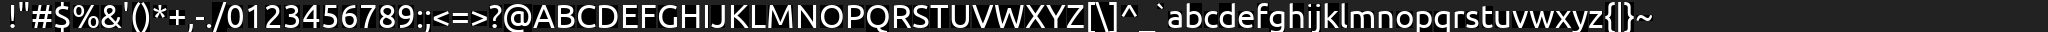

In [32]:
img_all = Image.new('L', (2048, 32), 0x22)
cur_x = 0

bb_height, yshift = get_y_stats(glyph_props)
print('bb_height:', bb_height, 'yshift:', yshift)

for i, p in enumerate(glyph_props):
    img_all.paste(getImg(i), (cur_x + p["lsb"], -p["tsb"] + 32 - yshift))
    cur_x += p["advance"]

img_all

# Debug

In [34]:
img = getImg(94, True)
img


0000: 00 00 23 b2 f1 ee a7 28 
0008: 00 00 00 00 00 1a de 97 
0010: 0c 00 1b e8 ff ff ff ff 
0018: fb 8c 0a 00 00 00 78 ff 
0020: ee 01 00 a0 ff ff ff ff 
0028: ff ff ff dc 54 0d 3a f2 
0030: ff a5 00 18 fa ff ac 0f 
0038: 22 93 fd ff ff ff ff ff 
0040: ff ff 31 00 62 ff f3 0f 
0048: 00 00 00 37 d0 ff ff ff 
0050: ff ff 92 00 00 47 b8 9c 
0058: 00 00 00 00 00 03 67 d1 
0060: f8 df 73 01 00 00 


# More debug

In [114]:
from font_converter import *


In [115]:
face = ft.Face('./Dosis-Medium.ttf')

In [112]:
test_string = '1234567890:'
target_height = 31 * 64
char_size = target_height

In [113]:
for i in range(6):
    face.set_char_size(height=char_size)
    props = [get_glyph(c, face)[1] for c in test_string]
    bb_height, yshift = get_y_stats(props)
    print(char_size / 64, bb_height / 64, yshift / 64)
    err = (target_height - bb_height)
    if err == 0:
        break
    char_size += err

31.0 24.0 5.0
38.0 29.0 2.5
40.0 31.0 1.5


In [117]:
auto_tune_font_size(face, 30*64)

30.0000, 23.0000, 5.5000
37.0000, 29.0000, 2.5000
38.0000, 29.0000, 2.5000
39.0000, 30.0000, 2.0000


(2496, 128)